# Предсказание заблокированных операций



**Титоренко Антой Александрович**

## Описание проекта

**Вводные**: *Операция клиента может быть заблокирована банком по требованию 115-ФЗ.* Исходя из истории предыдущих транзакций, атрибутов карточки клиента и некоторых показателей риска, учитывающих прошлые блокировки, нужно решить задачу бинарной классификации: определить, будут ли у клиента в конкретную дату операции, требующие блокировки.

*Представленные данные являются синтетическими, но они созданы на основе реальных данных и учитывают все закономерности, фактические распределения и влияние признаков.*

**Задача**: предсказать у каких клиентов будут блокировки.



**Files**
- train.csv - the training set
- test.csv - the test set
- client_measures.csv - признаки клиента на дату trigger_dt
- transactions.csv - транзакции клиента за 180 дней

**Columns**
- reg_code - код региона
- activity_code - код вида деятельности
- trxn_direction - направление транзакции (списание или зачисление)
- trxn_date - дата транзакции
- trxn_ammount - сумма транзакции

Остальные признаки не раскрываются.

## План работы

* Шаг 1: загрузка данных
  - загрузим датасеты и выполним первычный осмотр
* Шаг 2: Исследовательский анализ и предобработка
  - Выполним исследовательский анализ каждого датафрейма, при необходимости проведем предобработку
* Шаг 3: Подготовка данный к анализу
* Шаг 4: Обучение моделей машинного обучения
* Шаг 5: Выбор лучшей модели по метрике roc-auc на тестовой выборке
* Шаг 6: Общий вывод

## Этап 1. Исследовательский анализ данных

### Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
!pip install catboost
from catboost import CatBoostClassifier



# подбор параметров
!pip install optuna
import optuna

# для построения пайплайна
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#оценка качества
from sklearn.metrics import roc_auc_score

!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


import os
import time
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

RANDOM_STATE = 42


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.7 MB/s eta 0:00:00


### Загрузим данные

In [2]:

def load_and_read_file(filename):
    '''
    Напишем функцию для загрузки файлов.
    Если их нет в директории, то качаем с кагла.
    Предварительно нужно убедиться, что kaggle.json в директории
    '''
    try:
        return pd.read_csv(filename)
    except FileNotFoundError:
        if not os.path.isfile(filename):
            print(f"{filename} не найден. Загрузка с Kaggle")
            !kaggle competitions download -c compl-sber-ds-test
            !unzip compl-sber-ds-test.zip
        return pd.read_csv(filename)


In [3]:
!ls -lha kaggle.json

ls: cannot access 'kaggle.json': No such file or directory


Тут нужно вставить скачанный kaggle.json
https://www.kaggle.com/docs/api

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

files.upload() #грузим

Mounted at /content/gdrive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"antonti012","key":"d902279124d60fee318901fc78e34668"}'}

In [5]:
!ls -lha kaggle.json
!pip install -q kaggle


-rw-r--r-- 1 root root 66 Apr  8 15:15 kaggle.json


In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:

# читаем данные
client_measures = load_and_read_file('client_measures.csv')
transactions = load_and_read_file('transactions.csv')
train = load_and_read_file('train.csv')
test = load_and_read_file('test.csv')

client_measures.csv не найден. Загрузка с Kaggle
 48% 3.00M/6.21M [00:00<00:00, 16.8MB/s]
100% 6.21M/6.21M [00:00<00:00, 25.9MB/s]
Archive:  compl-sber-ds-test.zip
  inflating: client_measures.csv     
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


### Посмотрим на данные

In [9]:
# функция для первичного просмотра датасета
def first_view(data):
  print(f"Размер датасета: {data.shape}\n")

  print("Типы данных и пропущенные значения:")
  print(data.info(), "\n")

  print("Статистики для числовых признаков:")
  print(data.describe(), "\n")

  print("Уникальные значения для категориальных признаков:")
  categorical_columns = data.select_dtypes(include=['object', 'category']).columns
  unique_values = data[categorical_columns].nunique()
  print(unique_values)



In [10]:
# Функция для подсчета пропущенных значений
def missing_values_percentage(data):
  missing_percentage = data.isnull().sum() * 100 / len(data)
  missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
  return missing_percentage


**client_measures**

Колонки:
- client_id - клиентский id
- days_from_start - количество дней с регистрации
- reg_code - код региона
- activity_code - код вида деятельности

In [11]:
client_measures

,client_id,days_from_start,reg_code,activity_code,index_1,index_2,index_3,index_4
0,1,185.0,79.0,49.41,NaN,NaN,NaN,45.0
1,2,1932.0,79.0,43.21,NaN,0.0,NaN,NaN
2,3,9.0,79.0,47.91,NaN,0.0,NaN,NaN
3,4,19.0,79.0,41.20,NaN,NaN,NaN,NaN
4,5,48.0,80.0,1.41,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
35194,35339,10.0,45.0,46.74,NaN,NaN,NaN,61.0
35195,35340,13.0,45.0,46.73,NaN,0.0,l3,66.0
35196,35341,69.0,45.0,46.90,NaN,0.0,l2,48.0
35197,35342,7.0,45.0,43.21,NaN,0.0,NaN,61.0


In [13]:
first_view(client_measures)

Размер датасета: (35199, 8)

Типы данных и пропущенные значения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35199 entries, 0 to 35198
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   client_id        35199 non-null  int64  
 1   days_from_start  35199 non-null  float64
 2   reg_code         35178 non-null  float64
 3   activity_code    35199 non-null  float64
 4   index_1          697 non-null    float64
 5   index_2          18727 non-null  float64
 6   index_3          9749 non-null   object 
 7   index_4          17287 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.1+ MB
None 

Статистики для числовых признаков:
          client_id  days_from_start      reg_code  activity_code     index_1  \
count  35199.000000     35199.000000  35178.000000   35199.000000  697.000000   
mean   17668.035342       561.765079     47.625362      49.067439    1.461980   
std    10201.913649 

In [14]:
missing_values_percentage(client_measures)

index_1     98.019830
index_3     72.303190
index_4     50.887809
index_2     46.796784
reg_code     0.059661
dtype: float64

**Вывод:**

- Всего 35199 строк, 8 колонок;
- Все колонки, кроме index_3, имеют числовой тип данных. Колонка index_3 имеет тип данных object. Изуим в дальнейшем
-----
- Есть пропущенные значения в нескольких колонках:
  - reg_code 0.06% (21 пропущенное значение);
  - index_1 98% (34,502 пропущенных значений);
  - index_2 46.8% (16,472 пропущенных значений);
  - index_3 72.2% (25,450 пропущенных значений);
  - index_4 50.9% (17,912 пропущенных значений).
-----
- days_from_start имеет диапазон от 1 до 19,677 дней, в среднем 561, однако медиана на уровене 69 дней, что говорит о тяжелых правых хвостах в распределении;
- index_1, index_2, index_4 имеют различные распределения значений, некоторые из них имеют низкие средние значения и стандартные отклонения. Требуется проведение дополнительного анализа для понимания их влияния на модель;
- index_1 имеет 3 значения (кроме nan): 'l3', 'l2', 'l1'. Позже приведем к категориальным переменным.





**transactions.csv**

- trxn_direction - направление транзакции (списание или зачисление)
- trxn_date - дата транзакции
- trxn_ammount - сумма транзакции

In [15]:
transactions

,client_id,trxn_direction,trxn_date,trxn_ammount,fl_0,fl_1,fl_2,fl_3,fl_4,fl_5,fl_6,fl_7,fl_8,fl_9,fl_10,fl_11,fl_12,fl_13,fl_14,fl_15,fl_16,fl_17,fl_18,fl_19,fl_20,fl_21,fl_22,fl_23,fl_24,fl_25,fl_26,fl_27,fl_28,fl_29,fl_30,fl_31,fl_32,fl_33,fl_34,fl_35,fl_36,fl_37,fl_38,fl_39
0,23112,0,2023-12-26,2.79757,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,23112,1,2023-12-27,2.79757,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
2,20472,1,2023-12-01,2.00785,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,20472,0,2023-11-28,2.75568,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
4,20472,0,2023-11-23,2.46082,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
737903,8070,1,2023-05-19,2.22940,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
737904,8070,1,2023-05-19,0.14583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
737905,29319,1,2023-03-16,1.95547,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
737906,29319,1,2023-03-16,2.42167,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [16]:
first_view(transactions)

Размер датасета: (737908, 44)

Типы данных и пропущенные значения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737908 entries, 0 to 737907
Data columns (total 44 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   client_id       737908 non-null  int64  
 1   trxn_direction  737908 non-null  int64  
 2   trxn_date       737908 non-null  object 
 3   trxn_ammount    737908 non-null  float64
 4   fl_0            737908 non-null  int64  
 5   fl_1            737908 non-null  int64  
 6   fl_2            737908 non-null  int64  
 7   fl_3            737908 non-null  int64  
 8   fl_4            737908 non-null  int64  
 9   fl_5            737908 non-null  int64  
 10  fl_6            737908 non-null  int64  
 11  fl_7            737908 non-null  int64  
 12  fl_8            737908 non-null  int64  
 13  fl_9            737908 non-null  int64  
 14  fl_10           737908 non-null  int64  
 15  fl_11           737908 non-null  in

In [17]:
missing_values_percentage(transactions)

Series([], dtype: float64)

**Вывод:**
- Датасет состоит из 737908 строк и 44 колонок
- Формат у trxn_date object, следует перевести позже
- Пропусков нет
- Флаги f1_1 - f1_39 принимают значения 0/1. Пока не понятно, что делать с ними. Скорее всего, они свидетельствуют о характеристиках транзакций

**train**

In [19]:
train

,client_id,trigger_dt,target
0,2,2023-06-26,0
1,3,2023-04-23,0
2,4,2023-10-03,0
3,5,2023-07-06,0
4,6,2023-07-03,0
...,...,...,...
26000,35338,2023-03-07,0
26001,35339,2023-01-27,1
26002,35341,2023-06-26,1
26003,35342,2023-06-07,1


In [20]:
first_view(train)

Размер датасета: (26005, 3)

Типы данных и пропущенные значения:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26005 entries, 0 to 26004
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   client_id   26005 non-null  int64 
 1   trigger_dt  26005 non-null  object
 2   target      26005 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 609.6+ KB
None 

Статистики для числовых признаков:
          client_id        target
count  26005.000000  26005.000000
mean   17657.816958      0.282715
std    10212.598907      0.450328
min        2.000000      0.000000
25%     8841.000000      0.000000
50%    17659.000000      0.000000
75%    26537.000000      1.000000
max    35343.000000      1.000000 

Уникальные значения для категориальных признаков:
trigger_dt    299
dtype: int64


In [21]:
missing_values_percentage(train)

Series([], dtype: float64)

**Вывод:**

- Датасет содержит 26005 записей и 3 колонки;
- Пропусков нет;
- trigger_dt имеет тип object, надо в даты перевести
- target целевой признак, имеет бинарный тип данных, 1 - подозрительный клиент, 0 - нет.  Единиц 28.27%. Следовательно, нужно будет сбалансировать данные

----

Привежем признаки с датами в формат дат

In [22]:
def change_date_format(data, column):
  data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')

change_date_format(transactions, 'trxn_date')
change_date_format(train, 'trigger_dt')

### Графики

Напишем функцию **numeric_feature_distribution**, строящую графики распределения числовых признаков

In [23]:
def feature_distribution(data, features):
    plt.figure(figsize=(15, 5 * len(features)))
    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        sns.histplot(data[feature], bins=30)
        plt.title(f'Распределение для {feature}')
        plt.xlabel(feature)
        plt.ylabel('Количество')

    plt.tight_layout()
    plt.show()

Напишем функцию **categorical_feature_distribution**, строящую графики распределения категориальных признаков

In [24]:
def categorical_feature_distribution(data, feature):
  plt.figure(figsize=(10, 5))
  sns.countplot(x=feature, data=data)
  plt.title(f'Распределение для {feature}')
  plt.xlabel(feature)
  plt.ylabel('Количество')
  plt.xticks(rotation=45)
  plt.show()


#### Применим к **client_measures**

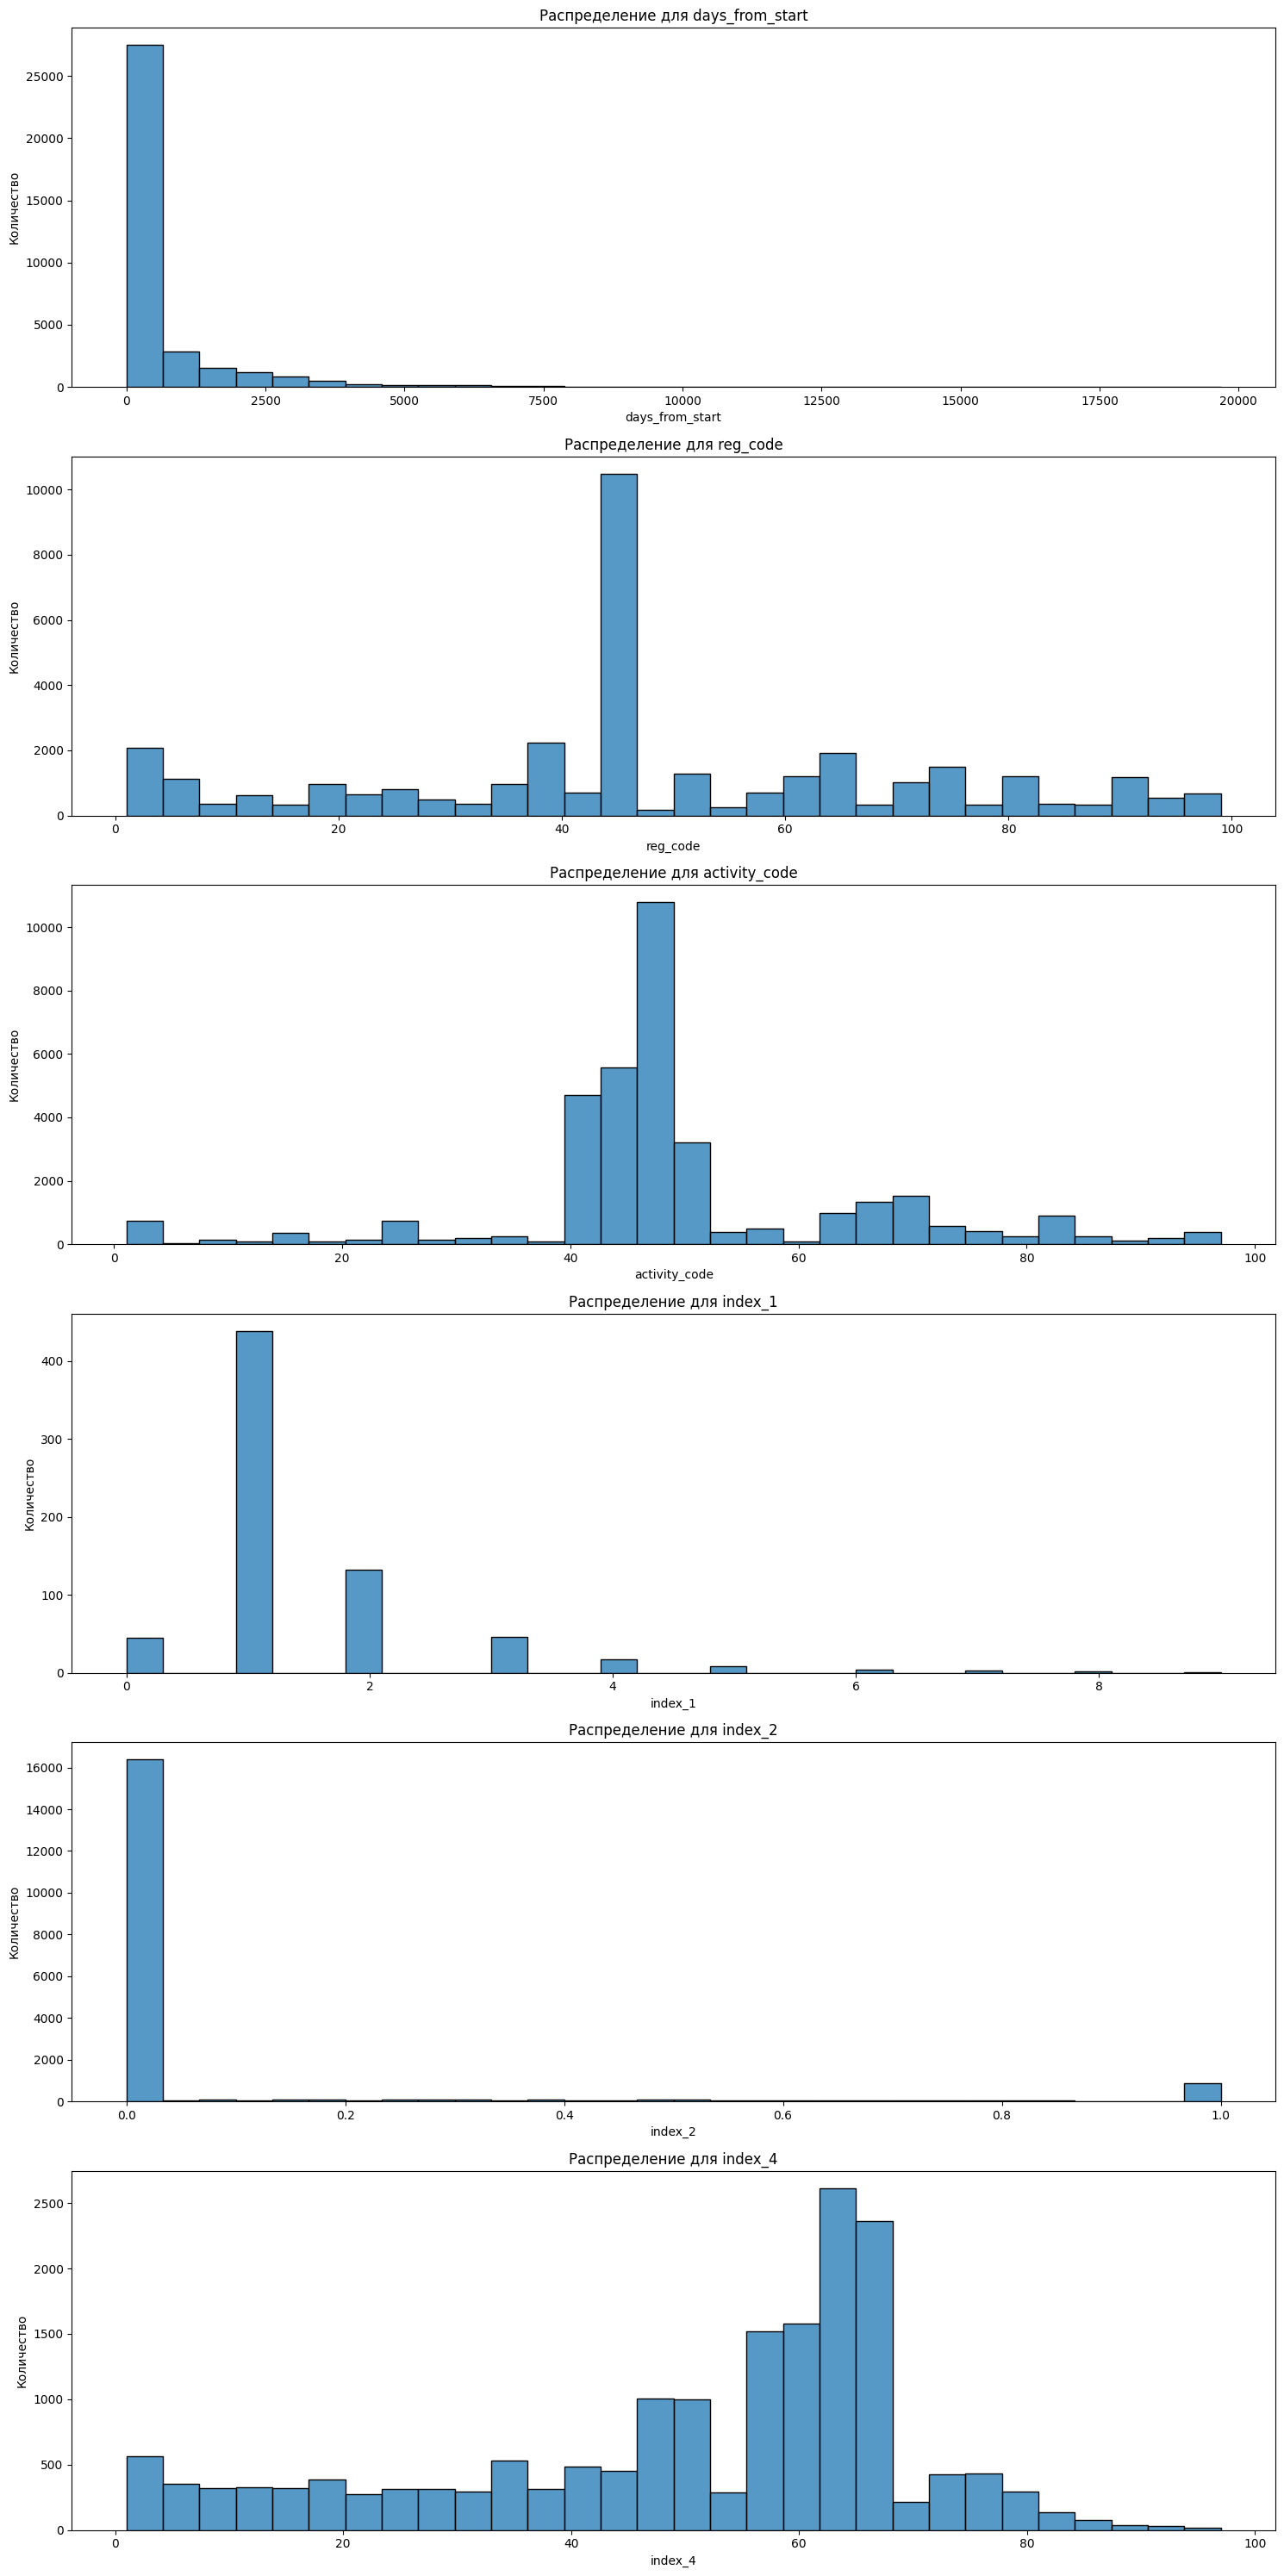

In [25]:
features = ['days_from_start', 'reg_code', 'activity_code', 'index_1', 'index_2', 'index_4']
feature_distribution(client_measures, features)

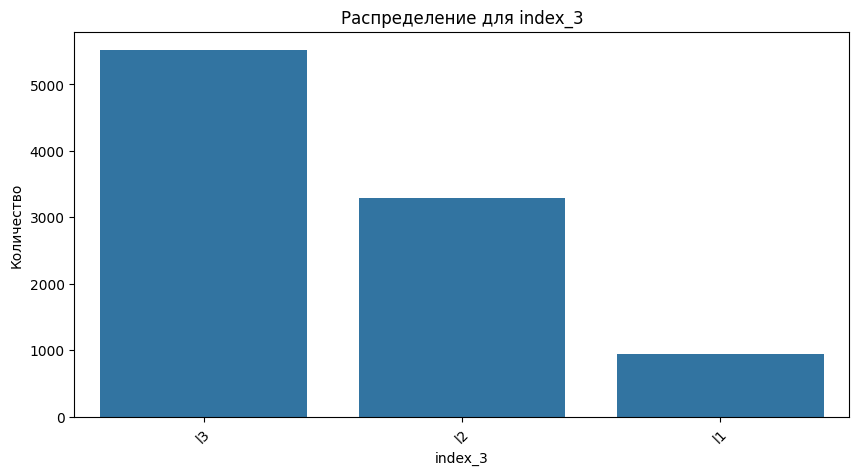

In [26]:
categorical_feature_distribution(client_measures, 'index_3')


#### Применим к **transactions**

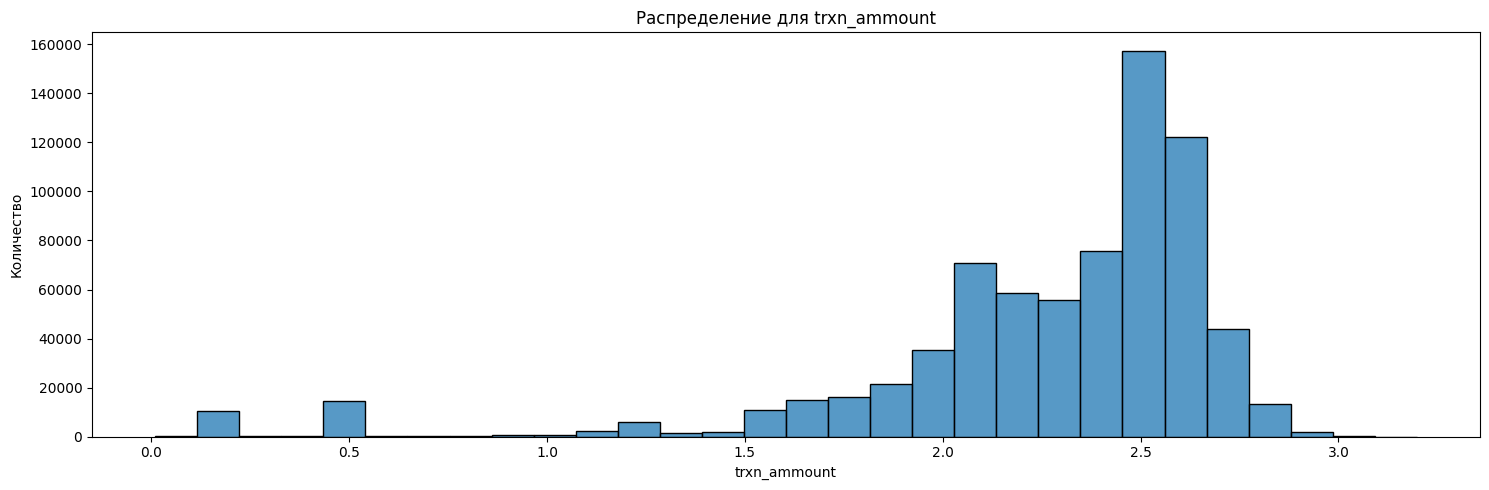

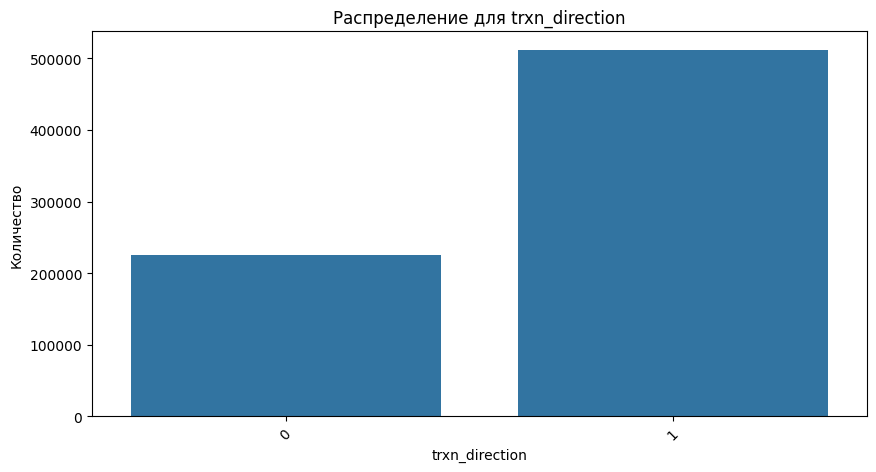

In [27]:
numerical_features = ['trxn_ammount']
feature_distribution(transactions, numerical_features)

categorical_feature_distribution(transactions, 'trxn_direction')


Транзакции распределены относительно нормально с длинным хвостом справа, среднее значение и медиана практически совпадают

Относительно trxn_direction, зачислений (1) значительно больше чем списаний (0). Эта информация может быть полезна для анализа поведения клиентов и тенденций в транзакционной активности.

#### Применим к train

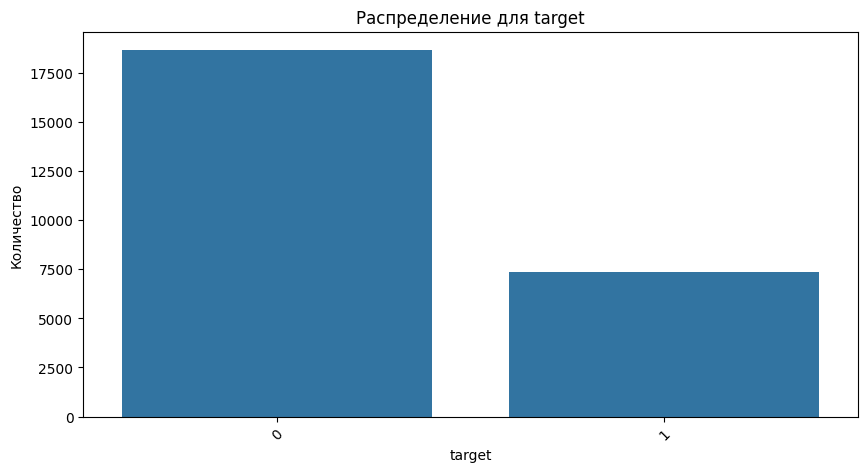

In [28]:
categorical_feature_distribution(train, 'target')


### Этап 2. Подготовка даннных для моделей

#### **Объедим в один датафрейм df**

Сделаем это по связке 'client_id' и 'trigger_dt', потому что в дальнейшем этом будем использовать как ключ

In [29]:
transactions['trigger_dt'] = transactions['trxn_date']

data = pd.merge(train, transactions, on=['client_id','trigger_dt'], how='left')
data = pd.merge(data, client_measures, on = 'client_id', how='left') # тут просто информация по клиентам

data.head()

,client_id,trigger_dt,target,trxn_direction,trxn_date,trxn_ammount,fl_0,fl_1,fl_2,fl_3,fl_4,fl_5,fl_6,fl_7,fl_8,fl_9,fl_10,fl_11,fl_12,fl_13,fl_14,fl_15,fl_16,fl_17,fl_18,fl_19,fl_20,fl_21,fl_22,fl_23,fl_24,fl_25,fl_26,fl_27,fl_28,fl_29,fl_30,fl_31,fl_32,fl_33,fl_34,fl_35,fl_36,fl_37,fl_38,fl_39,days_from_start,reg_code,activity_code,index_1,index_2,index_3,index_4
0,2,2023-06-26,0,1.0,2023-06-26,2.61092,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1932.0,79.0,43.21,NaN,0.0,NaN,NaN
1,3,2023-04-23,0,0.0,2023-04-23,2.52676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,79.0,47.91,NaN,0.0,NaN,NaN
2,4,2023-10-03,0,0.0,2023-10-03,2.61586,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,79.0,41.20,NaN,NaN,NaN,NaN
3,4,2023-10-03,0,0.0,2023-10-03,2.19797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,79.0,41.20,NaN,NaN,NaN,NaN
4,5,2023-07-06,0,1.0,2023-07-06,2.74896,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,80.0,1.41,NaN,0.0,NaN,NaN


In [30]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96208 entries, 0 to 96207
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   client_id        96208 non-null  int64         
 1   trigger_dt       96208 non-null  datetime64[ns]
 2   target           96208 non-null  int64         
 3   trxn_direction   93031 non-null  float64       
 4   trxn_date        93031 non-null  datetime64[ns]
 5   trxn_ammount     93031 non-null  float64       
 6   fl_0             93031 non-null  float64       
 7   fl_1             93031 non-null  float64       
 8   fl_2             93031 non-null  float64       
 9   fl_3             93031 non-null  float64       
 10  fl_4             93031 non-null  float64       
 11  fl_5             93031 non-null  float64       
 12  fl_6             93031 non-null  float64       
 13  fl_7             93031 non-null  float64       
 14  fl_8             93031 non-null  float

In [31]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_columns.remove('client_id')


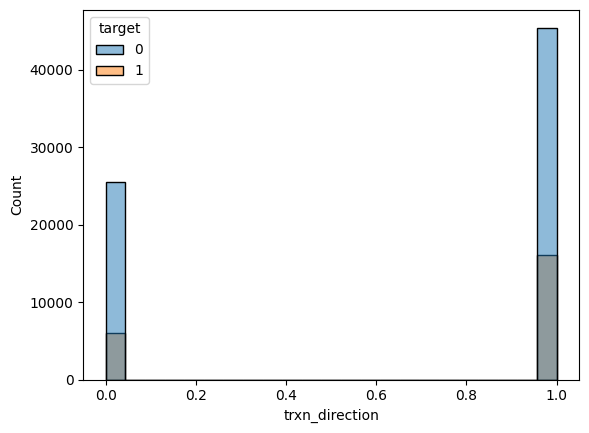

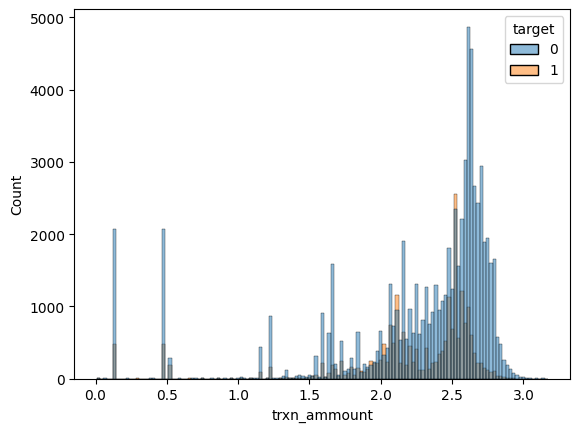

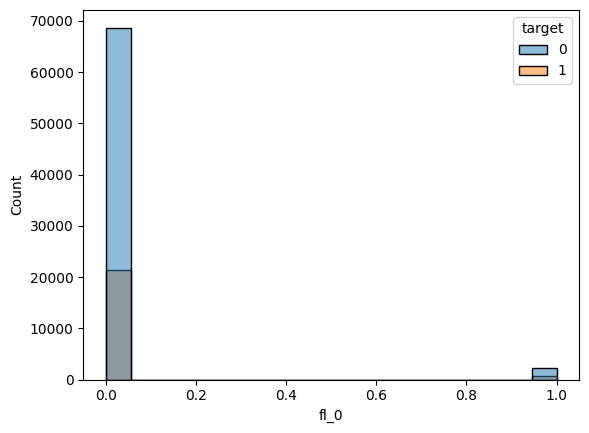

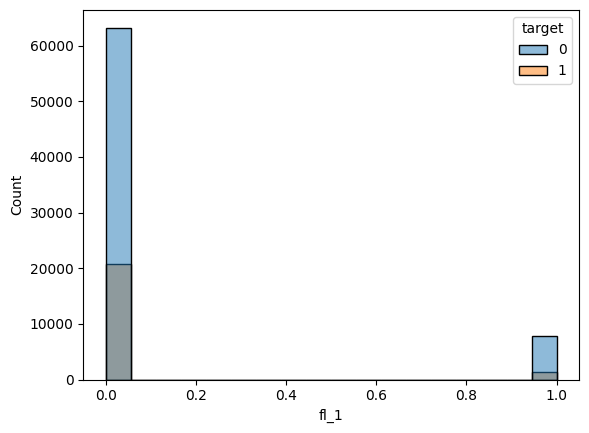

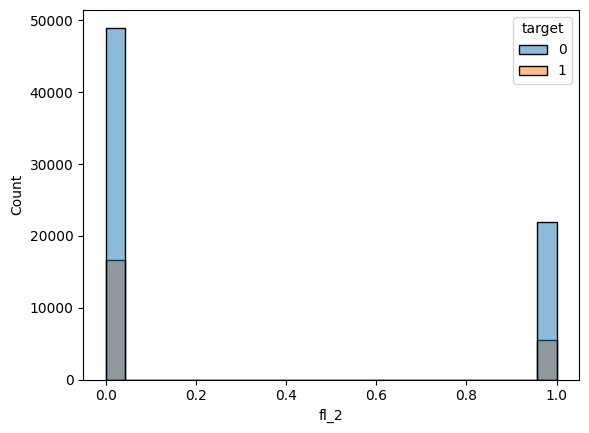

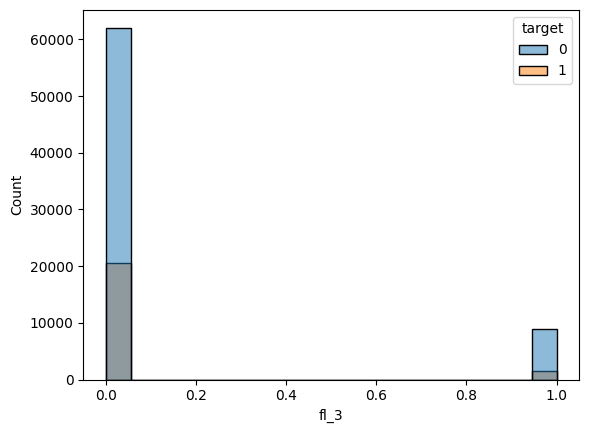

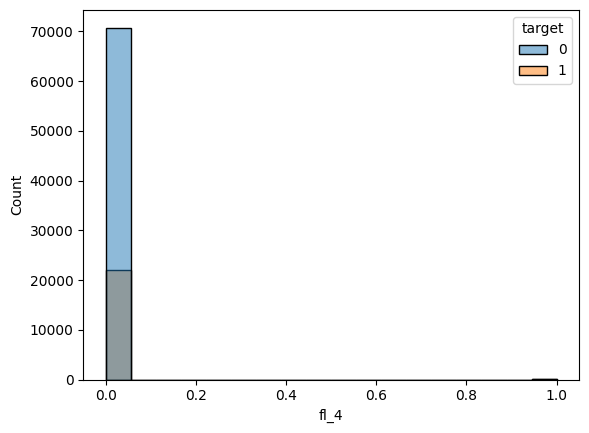

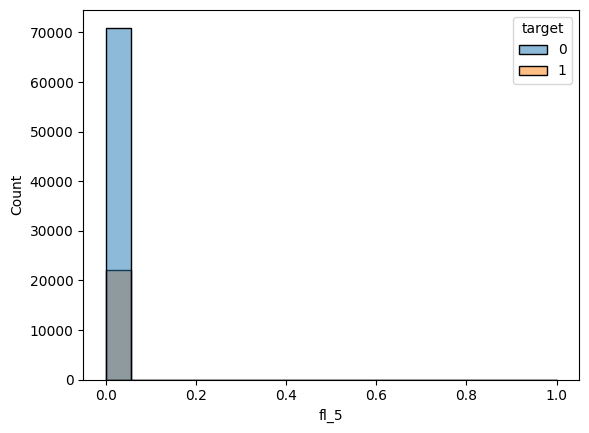

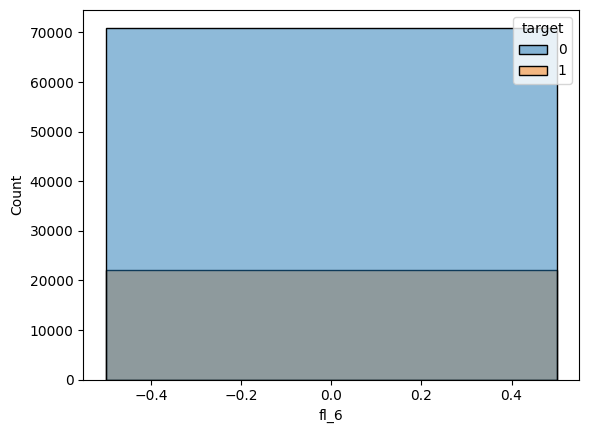

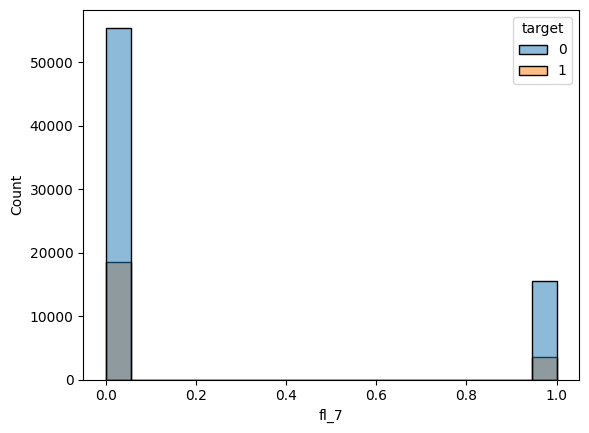

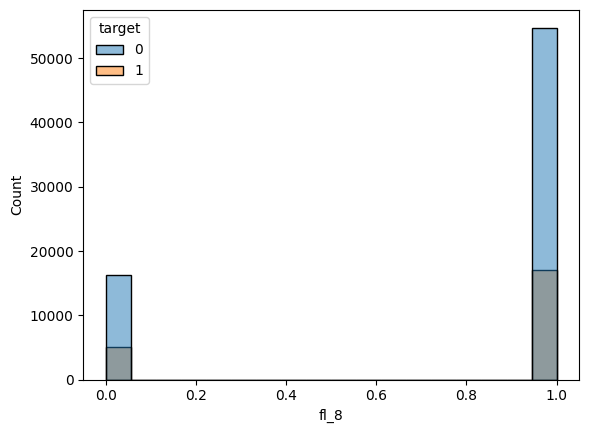

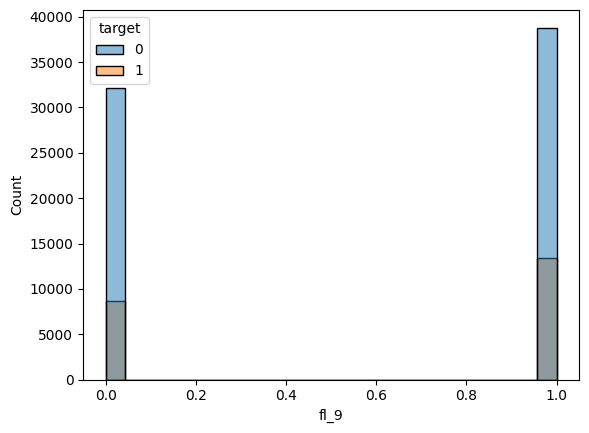

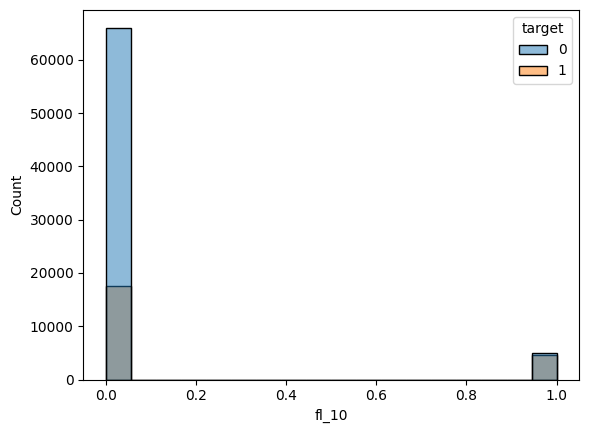

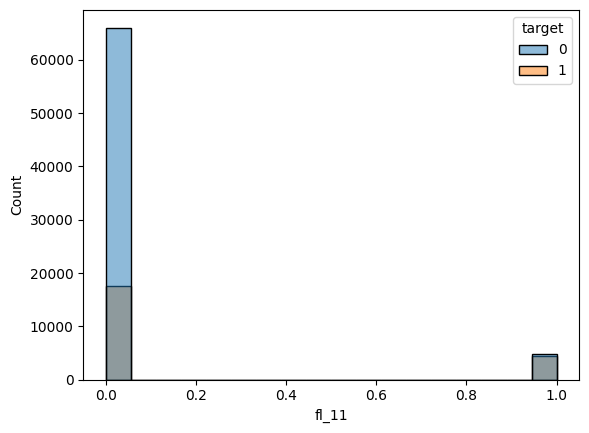

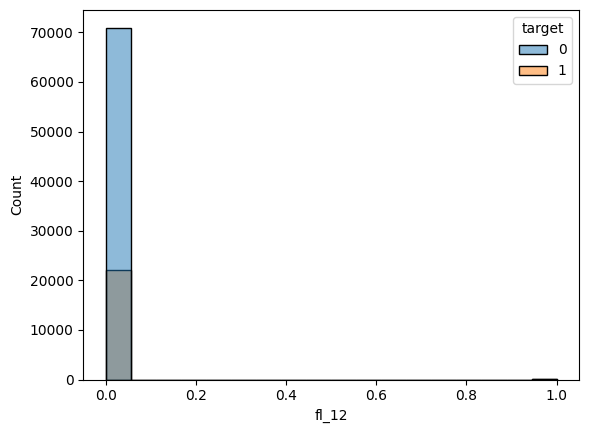

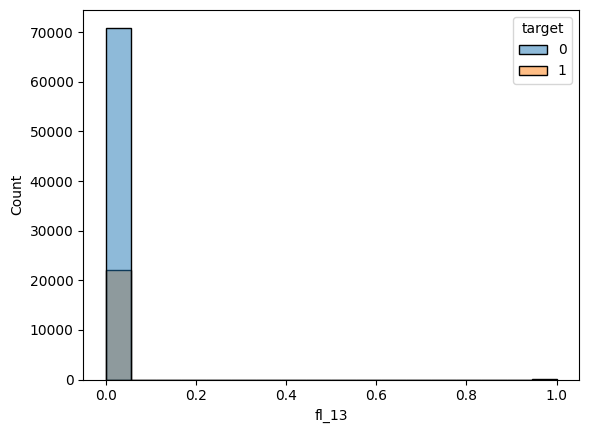

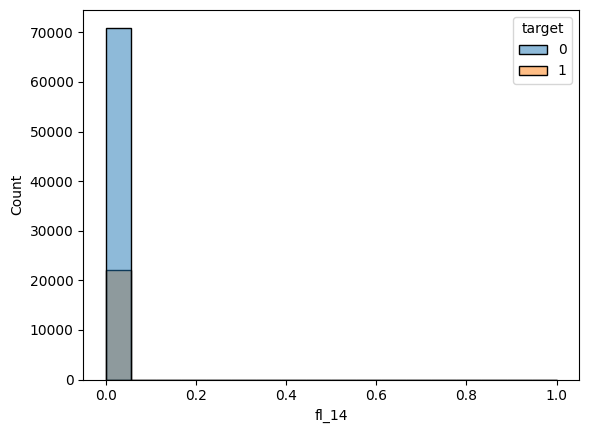

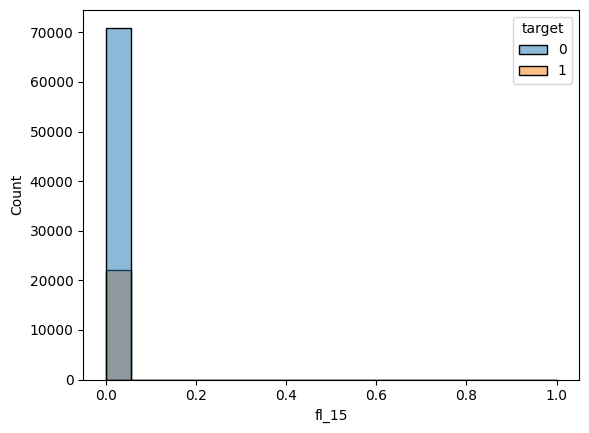

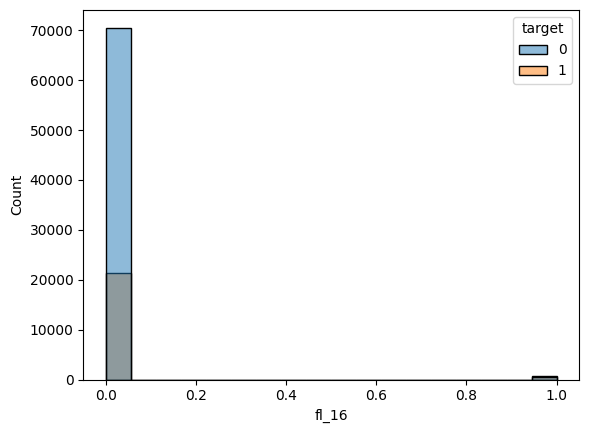

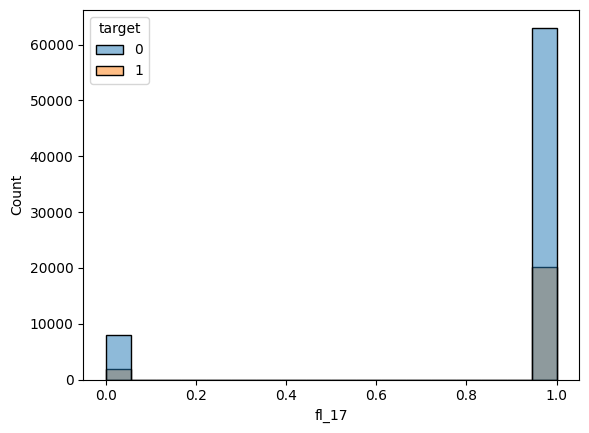

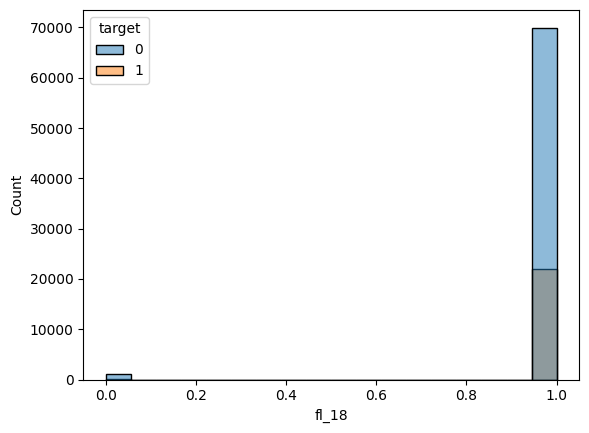

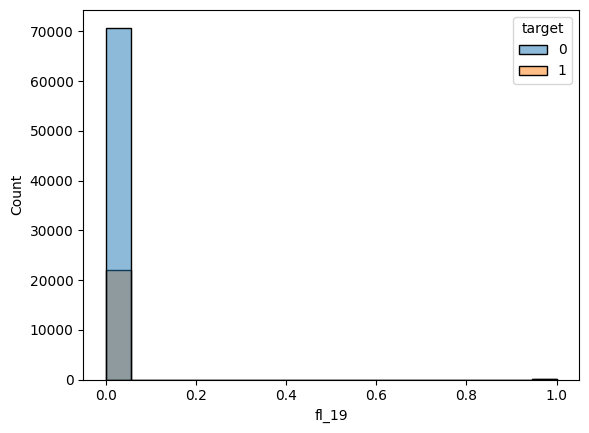

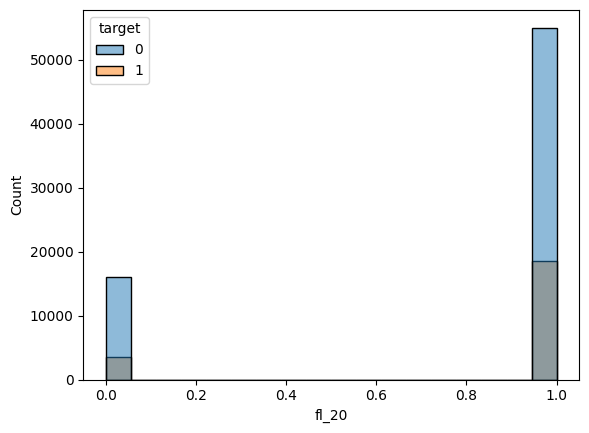

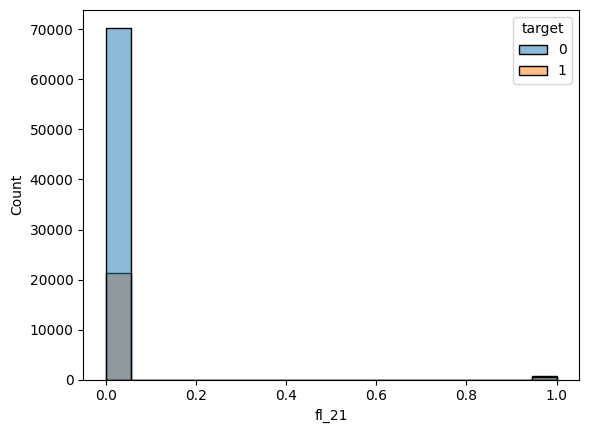

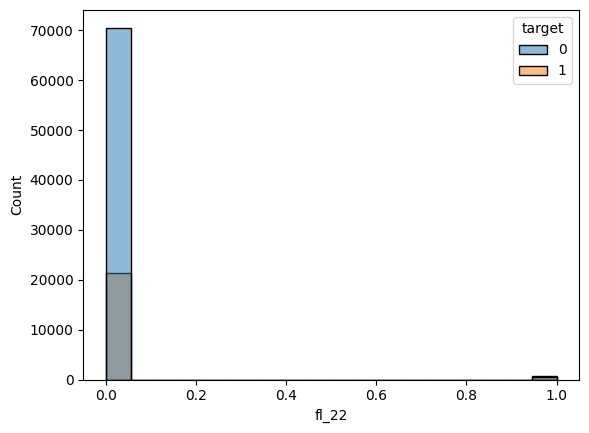

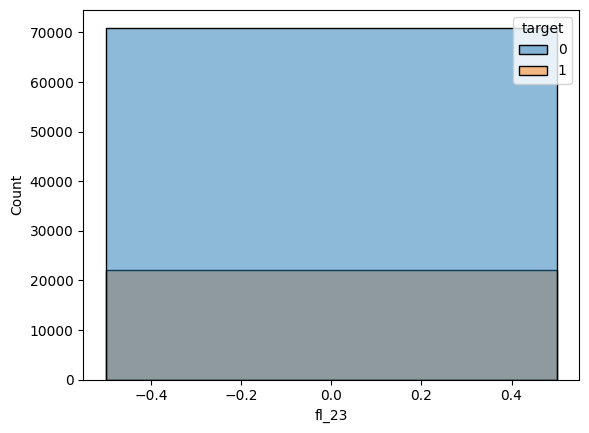

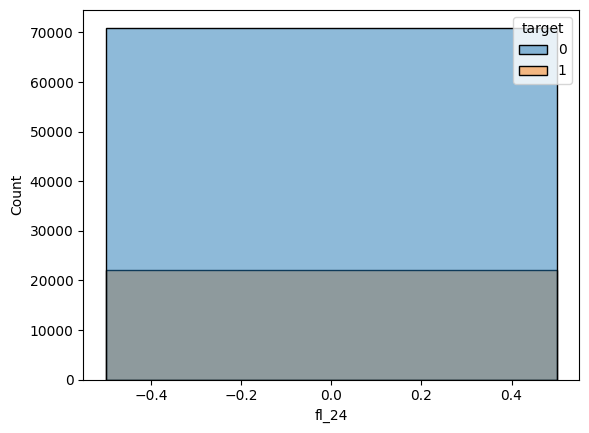

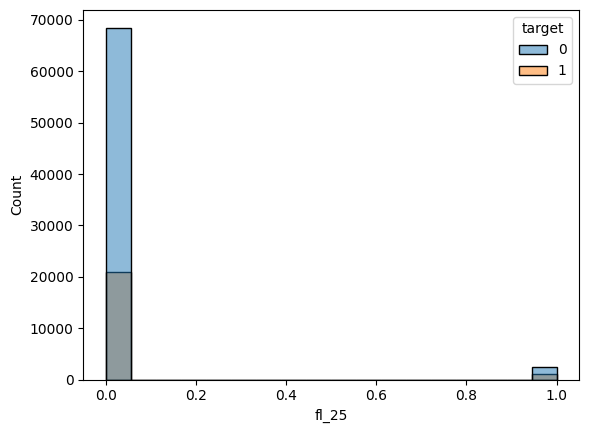

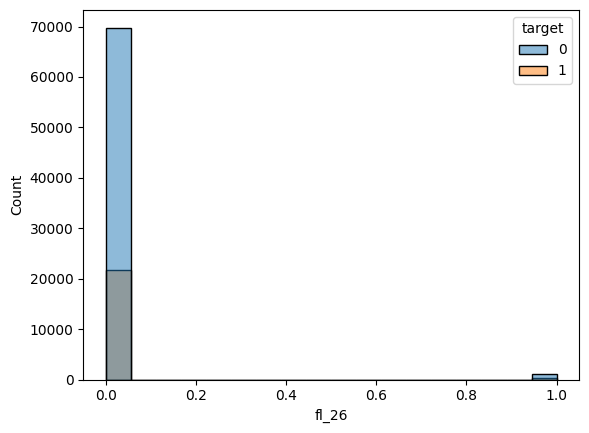

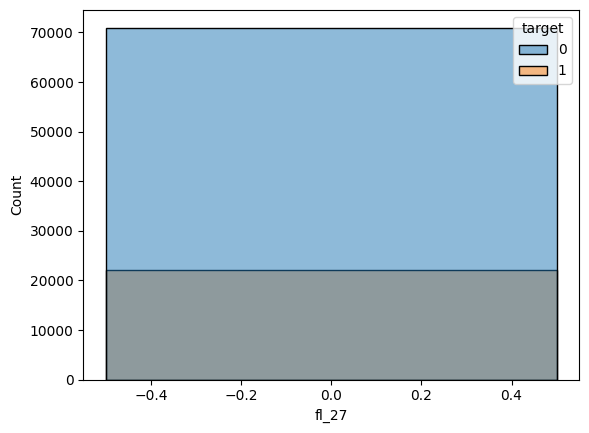

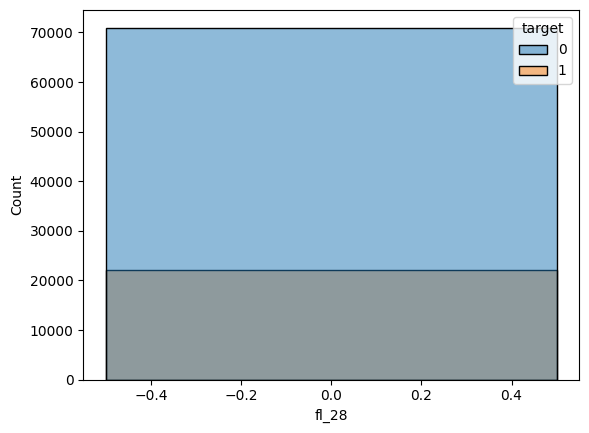

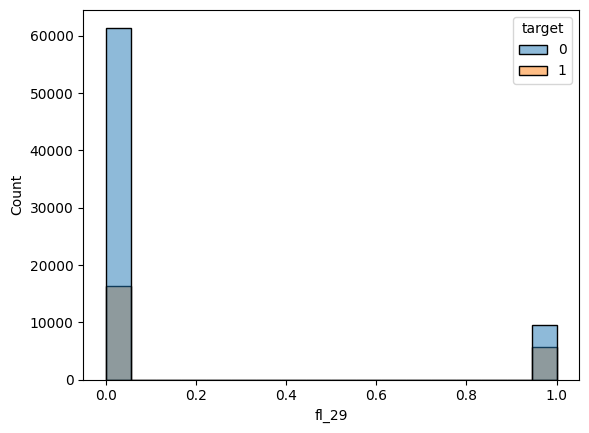

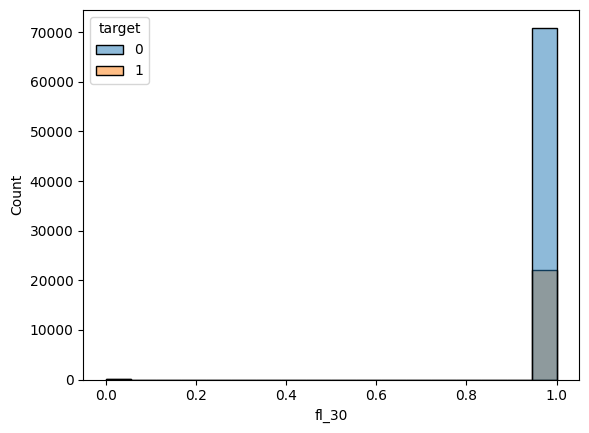

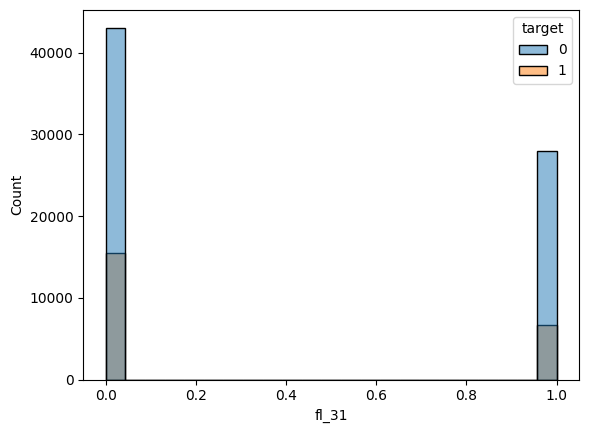

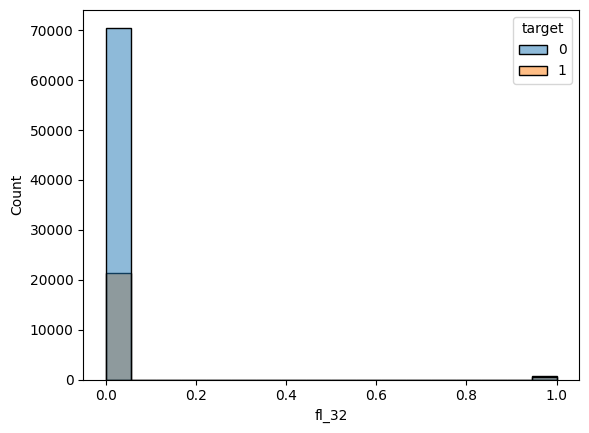

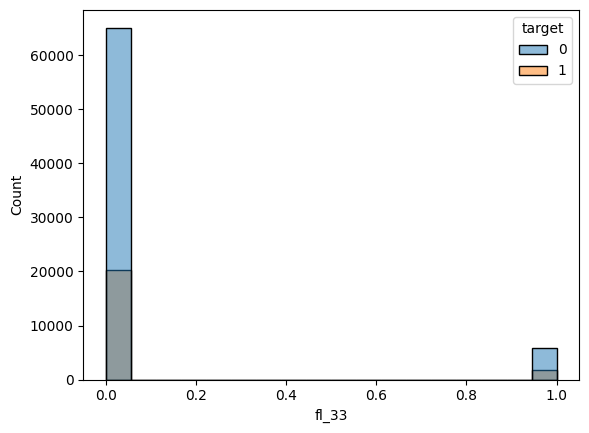

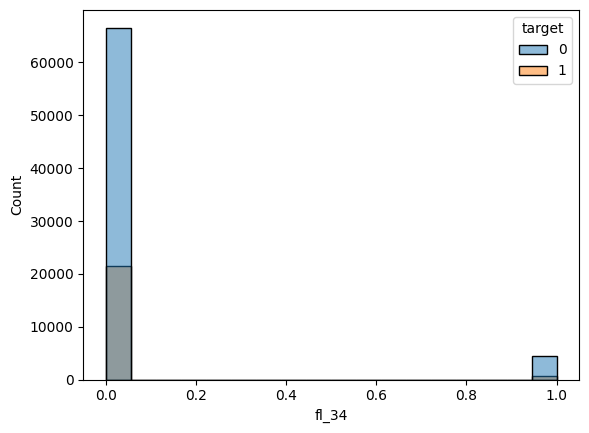

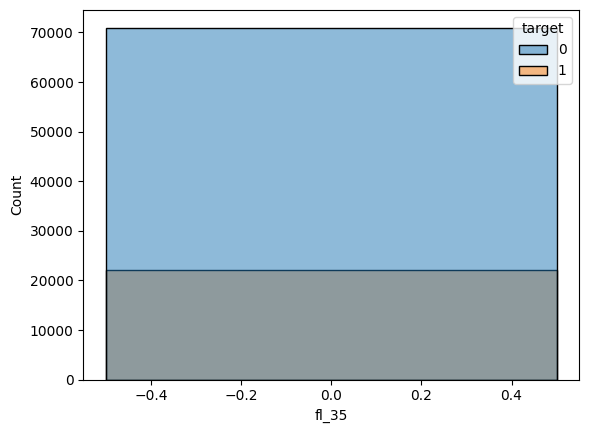

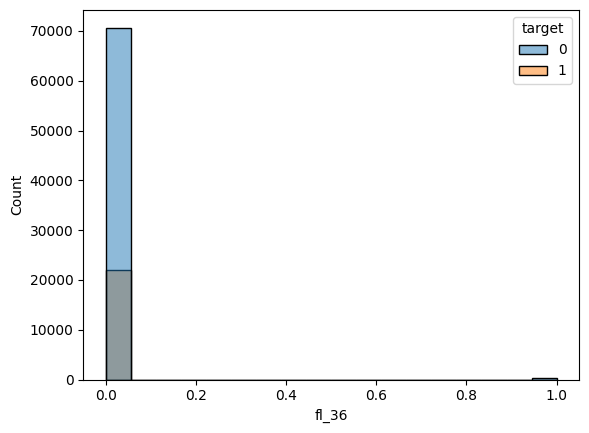

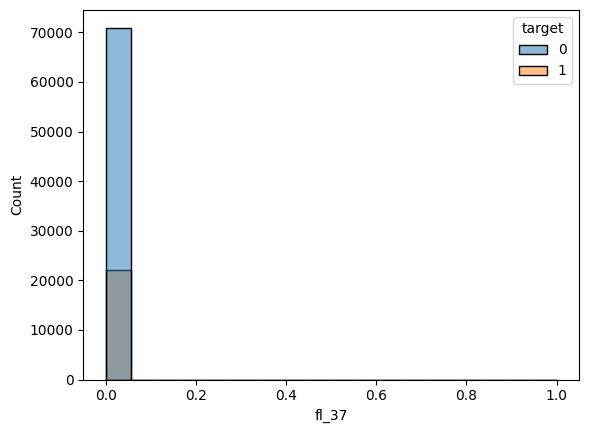

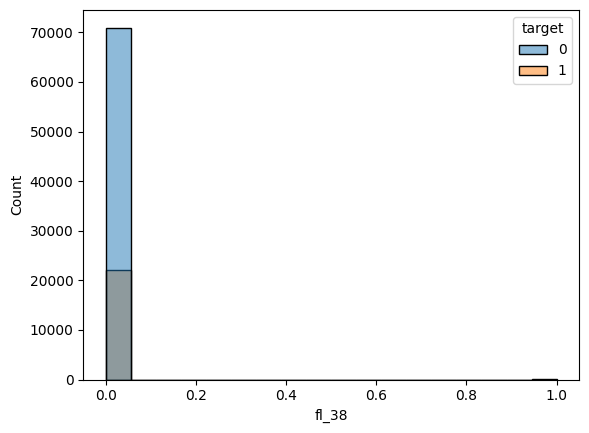

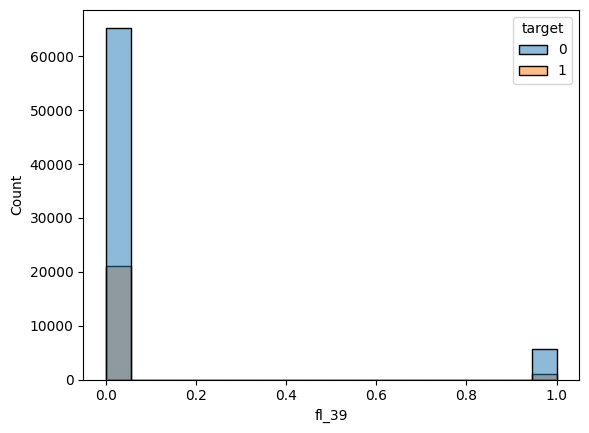

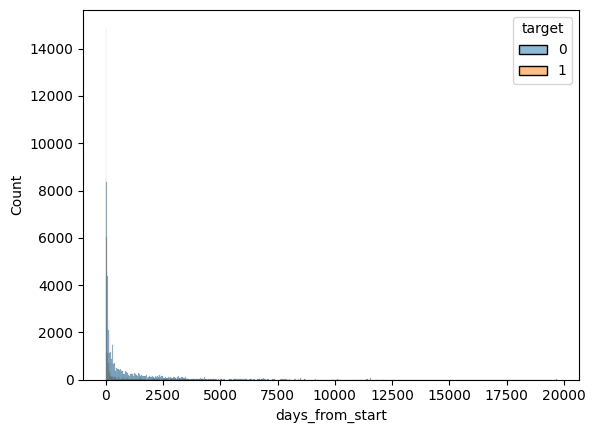

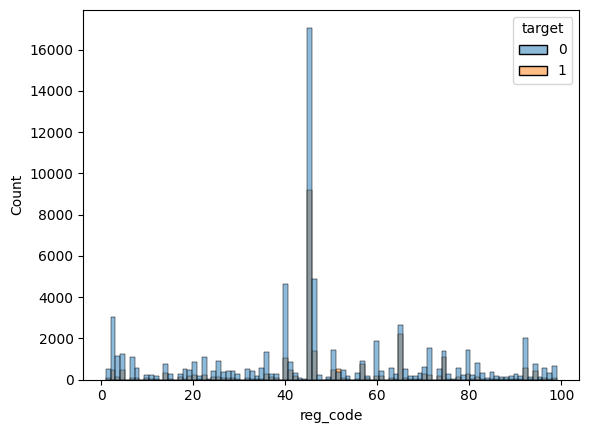

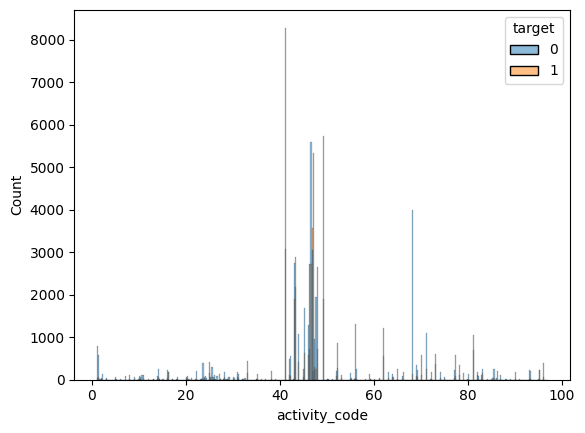

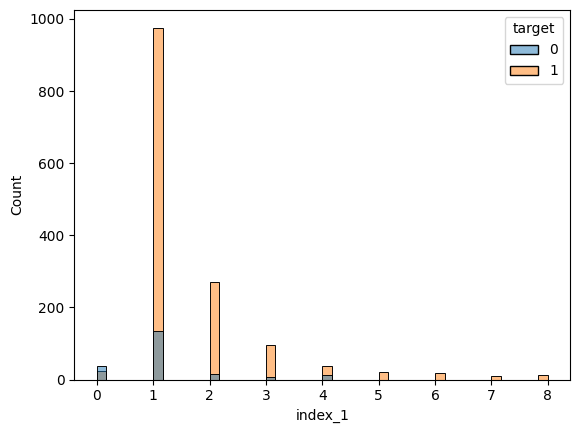

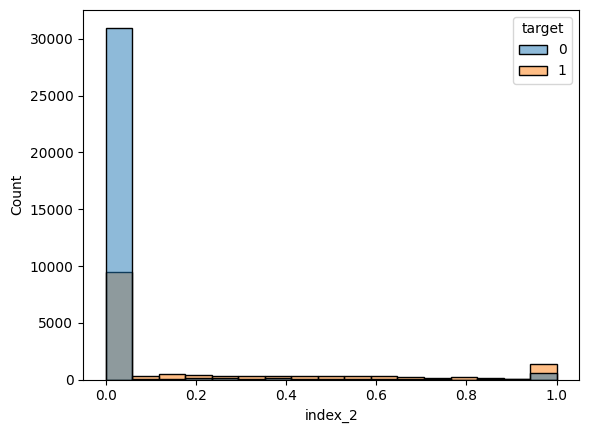

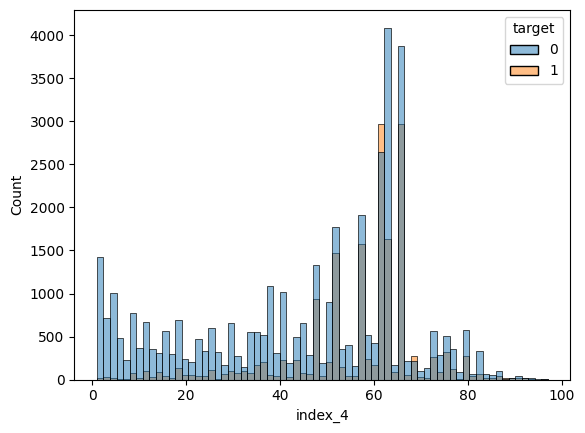

In [32]:
# Посмотрим на распределение переменных относительно таргета

for column in numeric_columns:
    if column != 'target':
        sns.histplot(data=data, x=column, hue='target', alpha=0.5)
        plt.show()

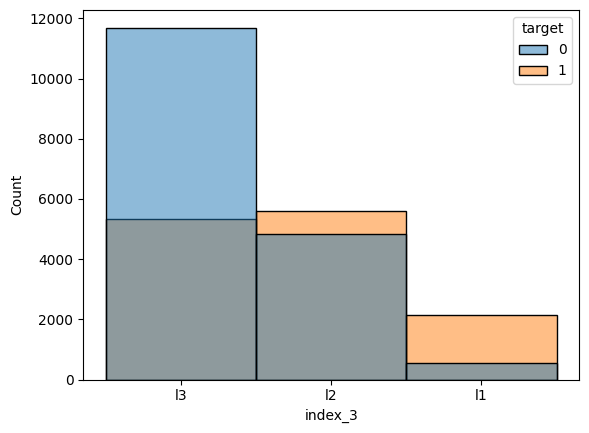

In [33]:
sns.histplot(data=data, x='index_3', hue='target', alpha=0.5)
plt.show()

Тоже самое для тестовой выборки

#### **Объедим в один датафрейм test**


In [34]:
# добавим колонку trigger_dt для связки
test['trigger_dt'] = pd.to_datetime(test['trigger_dt'])

df_test = pd.merge(test, transactions, on=['client_id','trigger_dt'], how='left')
df_test = pd.merge(df_test, client_measures, on = 'client_id', how='left')

df_test.head()

,client_id,trigger_dt,trxn_direction,trxn_date,trxn_ammount,fl_0,fl_1,fl_2,fl_3,fl_4,fl_5,fl_6,fl_7,fl_8,fl_9,fl_10,fl_11,fl_12,fl_13,fl_14,fl_15,fl_16,fl_17,fl_18,fl_19,fl_20,fl_21,fl_22,fl_23,fl_24,fl_25,fl_26,fl_27,fl_28,fl_29,fl_30,fl_31,fl_32,fl_33,fl_34,fl_35,fl_36,fl_37,fl_38,fl_39,days_from_start,reg_code,activity_code,index_1,index_2,index_3,index_4
0,1,2023-10-27,1.0,2023-10-27,2.61092,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,185.0,79.0,49.41,NaN,NaN,NaN,45.0
1,1,2023-10-27,1.0,2023-10-27,2.61092,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,185.0,79.0,49.41,NaN,NaN,NaN,45.0
2,1,2023-10-27,1.0,2023-10-27,2.64776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,79.0,49.41,NaN,NaN,NaN,45.0
3,1,2023-10-27,0.0,2023-10-27,2.79880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,79.0,49.41,NaN,NaN,NaN,45.0
4,1,2023-10-27,1.0,2023-10-27,2.78340,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,79.0,49.41,NaN,NaN,NaN,45.0


#### Работа с категориальными переменными df

In [35]:
# Много пропусков, сделаем дамми переменные

data['index_1'].isna().sum(), data['index_3'].isna().sum()

(94535, 66044)

In [36]:
df = pd.get_dummies(data, columns=['index_1', 'index_3'], dummy_na=True, drop_first=True)
df["without_trx"] = df["trxn_date"].isna() #если нет транзакции в этот день

df.head()

,client_id,trigger_dt,target,trxn_direction,trxn_date,trxn_ammount,fl_0,fl_1,fl_2,fl_3,fl_4,fl_5,fl_6,fl_7,fl_8,fl_9,fl_10,fl_11,fl_12,fl_13,fl_14,fl_15,fl_16,fl_17,fl_18,fl_19,fl_20,fl_21,fl_22,fl_23,fl_24,fl_25,fl_26,fl_27,fl_28,fl_29,fl_30,fl_31,fl_32,fl_33,fl_34,fl_35,fl_36,fl_37,fl_38,fl_39,days_from_start,reg_code,activity_code,index_2,index_4,index_1_1.0,index_1_2.0,index_1_3.0,index_1_4.0,index_1_5.0,index_1_6.0,index_1_7.0,index_1_8.0,index_1_nan,index_3_l2,index_3_l3,index_3_nan,without_trx
0,2,2023-06-26,0,1.0,2023-06-26,2.61092,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1932.0,79.0,43.21,0.0,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False
1,3,2023-04-23,0,0.0,2023-04-23,2.52676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,79.0,47.91,0.0,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False
2,4,2023-10-03,0,0.0,2023-10-03,2.61586,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,79.0,41.20,NaN,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False
3,4,2023-10-03,0,0.0,2023-10-03,2.19797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,79.0,41.20,NaN,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False
4,5,2023-07-06,0,1.0,2023-07-06,2.74896,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.0,80.0,1.41,0.0,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96208 entries, 0 to 96207
Data columns (total 64 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   client_id        96208 non-null  int64         
 1   trigger_dt       96208 non-null  datetime64[ns]
 2   target           96208 non-null  int64         
 3   trxn_direction   93031 non-null  float64       
 4   trxn_date        93031 non-null  datetime64[ns]
 5   trxn_ammount     93031 non-null  float64       
 6   fl_0             93031 non-null  float64       
 7   fl_1             93031 non-null  float64       
 8   fl_2             93031 non-null  float64       
 9   fl_3             93031 non-null  float64       
 10  fl_4             93031 non-null  float64       
 11  fl_5             93031 non-null  float64       
 12  fl_6             93031 non-null  float64       
 13  fl_7             93031 non-null  float64       
 14  fl_8             93031 non-null  float

#### Работа с категориальными переменными test

In [38]:
df_test = pd.get_dummies(df_test, columns=['index_1', 'index_3'], dummy_na=True, drop_first=True)
df_test["without_trx"] = df_test["trxn_date"].isna() #если нет транзакции в этот день
df_test.head()

,client_id,trigger_dt,trxn_direction,trxn_date,trxn_ammount,fl_0,fl_1,fl_2,fl_3,fl_4,fl_5,fl_6,fl_7,fl_8,fl_9,fl_10,fl_11,fl_12,fl_13,fl_14,fl_15,fl_16,fl_17,fl_18,fl_19,fl_20,fl_21,fl_22,fl_23,fl_24,fl_25,fl_26,fl_27,fl_28,fl_29,fl_30,fl_31,fl_32,fl_33,fl_34,fl_35,fl_36,fl_37,fl_38,fl_39,days_from_start,reg_code,activity_code,index_2,index_4,index_1_1.0,index_1_2.0,index_1_3.0,index_1_4.0,index_1_5.0,index_1_6.0,index_1_9.0,index_1_nan,index_3_l2,index_3_l3,index_3_nan,without_trx
0,1,2023-10-27,1.0,2023-10-27,2.61092,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,True,False,False,True,False
1,1,2023-10-27,1.0,2023-10-27,2.61092,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,True,False,False,True,False
2,1,2023-10-27,1.0,2023-10-27,2.64776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,True,False,False,True,False
3,1,2023-10-27,0.0,2023-10-27,2.79880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,True,False,False,True,False
4,1,2023-10-27,1.0,2023-10-27,2.78340,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,True,False,False,True,False


In [39]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31578 entries, 0 to 31577
Data columns (total 62 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   client_id        31578 non-null  int64         
 1   trigger_dt       31578 non-null  datetime64[ns]
 2   trxn_direction   30431 non-null  float64       
 3   trxn_date        30431 non-null  datetime64[ns]
 4   trxn_ammount     30431 non-null  float64       
 5   fl_0             30431 non-null  float64       
 6   fl_1             30431 non-null  float64       
 7   fl_2             30431 non-null  float64       
 8   fl_3             30431 non-null  float64       
 9   fl_4             30431 non-null  float64       
 10  fl_5             30431 non-null  float64       
 11  fl_6             30431 non-null  float64       
 12  fl_7             30431 non-null  float64       
 13  fl_8             30431 non-null  float64       
 14  fl_9             30431 non-null  float

#### Проверяем, все ли колонки совпадают

In [40]:

set(df.columns.tolist()) - set(df_test.columns.tolist())

{'index_1_7.0', 'index_1_8.0', 'target'}

добавим эти индексы со значением False

In [41]:
df_test['index_1_7.0'] = False
df_test['index_1_8.0'] = False

### Обучение моделей

In [42]:
# сохраним связку id + дата, чтобы потом подставить

ids = df['client_id'].astype(str) + "_" + df["trigger_dt"].dt.strftime('%Y-%m-%d')
ids_test = df_test['client_id'].astype(str)+ "_" + df_test['trigger_dt'].dt.strftime('%Y-%m-%d')

# сохраним таргеты
y = df['target']

#дропним лишние данные
df.drop(['trigger_dt', 'trxn_date', 'client_id', 'target'], axis=1, inplace=True)
df_test.drop(['trigger_dt', 'trxn_date', 'client_id'], axis=1, inplace=True)

In [43]:
# Определение числовых признаков: trxn_ammount + все флаги
numeric_features = ['trxn_ammount'] + [f'fl_{i}' for i in range(40)]

# Создание пайплайна для обработки числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Создание трансформера для применения пайплайна к числовым признакам
preprocessor = ColumnTransformer(
    transformers=[
      ('num', numeric_transformer, numeric_features)],
      remainder='passthrough'  # Оставить остальные колонки без изменений
)

# Применение пайплайна к данным
df_preprocessed = pd.DataFrame(preprocessor.fit_transform(df),
                                 columns=numeric_features + [col for col in df.columns if col not in numeric_features])

df_test_preprocessed = pd.DataFrame(preprocessor.transform(df_test),
                                 columns=numeric_features + [col for col in df.columns if col not in numeric_features])

# Восстановление порядка колонок
df_preprocessed = df_preprocessed[df.columns]
df_test_preprocessed = df_test_preprocessed[df.columns]



Посмотрим

In [44]:
df_preprocessed.head()

,trxn_direction,trxn_ammount,fl_0,fl_1,fl_2,fl_3,fl_4,fl_5,fl_6,fl_7,fl_8,fl_9,fl_10,fl_11,fl_12,fl_13,fl_14,fl_15,fl_16,fl_17,fl_18,fl_19,fl_20,fl_21,fl_22,fl_23,fl_24,fl_25,fl_26,fl_27,fl_28,fl_29,fl_30,fl_31,fl_32,fl_33,fl_34,fl_35,fl_36,fl_37,fl_38,fl_39,days_from_start,reg_code,activity_code,index_2,index_4,index_1_1.0,index_1_2.0,index_1_3.0,index_1_4.0,index_1_5.0,index_1_6.0,index_1_7.0,index_1_8.0,index_1_nan,index_3_l2,index_3_l3,index_3_nan,without_trx
0,1.0,0.591074,-0.179713,-0.323196,-0.631908,2.879249,-0.047656,-0.004559,0.0,-0.496301,0.533083,0.858039,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,0.503999,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,2.304695,0.038447,-0.748531,-0.107594,-0.29316,4.258456,0.0,-0.055835,-0.009672,-0.015464,-0.272715,1932.0,79.0,43.21,0.0,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False
1,0.0,0.45019,-0.179713,-0.323196,-0.631908,-0.347313,-0.047656,-0.004559,0.0,-0.496301,0.533083,0.858039,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,0.503999,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,-0.433897,0.038447,-0.748531,-0.107594,-0.29316,-0.234827,0.0,-0.055835,-0.009672,-0.015464,-0.272715,9.0,79.0,47.91,0.0,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False
2,0.0,0.599343,-0.179713,3.094102,-0.631908,-0.347313,-0.047656,-0.004559,0.0,2.014907,0.533083,-1.165449,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,-1.984132,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,-0.433897,0.038447,1.33595,-0.107594,-0.29316,-0.234827,0.0,-0.055835,-0.009672,-0.015464,-0.272715,19.0,79.0,41.2,NaN,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False
3,0.0,-0.100206,-0.179713,-0.323196,-0.631908,-0.347313,-0.047656,-0.004559,0.0,-0.496301,0.533083,0.858039,3.022708,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,0.503999,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,-0.433897,0.038447,-0.748531,-0.107594,-0.29316,-0.234827,0.0,-0.055835,-0.009672,-0.015464,-0.272715,19.0,79.0,41.2,NaN,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False
4,1.0,0.822153,-0.179713,-0.323196,1.582509,-0.347313,-0.047656,-0.004559,0.0,-0.496301,0.533083,0.858039,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,0.503999,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,-0.433897,0.038447,1.33595,-0.107594,-0.29316,-0.234827,0.0,-0.055835,-0.009672,-0.015464,-0.272715,48.0,80.0,1.41,0.0,NaN,False,False,False,False,False,False,False,False,True,False,False,True,False


In [45]:
df_test_preprocessed.head()

,trxn_direction,trxn_ammount,fl_0,fl_1,fl_2,fl_3,fl_4,fl_5,fl_6,fl_7,fl_8,fl_9,fl_10,fl_11,fl_12,fl_13,fl_14,fl_15,fl_16,fl_17,fl_18,fl_19,fl_20,fl_21,fl_22,fl_23,fl_24,fl_25,fl_26,fl_27,fl_28,fl_29,fl_30,fl_31,fl_32,fl_33,fl_34,fl_35,fl_36,fl_37,fl_38,fl_39,days_from_start,reg_code,activity_code,index_2,index_4,index_1_1.0,index_1_2.0,index_1_3.0,index_1_4.0,index_1_5.0,index_1_6.0,index_1_7.0,index_1_8.0,index_1_nan,index_3_l2,index_3_l3,index_3_nan,without_trx
0,1.0,0.591074,-0.179713,-0.323196,-0.631908,2.879249,-0.047656,-0.004559,0.0,-0.496301,0.533083,0.858039,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,0.503999,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,2.304695,0.038447,-0.748531,-0.107594,3.41111,-0.234827,0.0,-0.055835,-0.009672,-0.015464,3.66683,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,False,True,False,False,True,False
1,1.0,0.591074,-0.179713,-0.323196,-0.631908,2.879249,-0.047656,-0.004559,0.0,-0.496301,0.533083,0.858039,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,0.503999,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,2.304695,0.038447,-0.748531,-0.107594,-0.29316,4.258456,0.0,-0.055835,-0.009672,-0.015464,-0.272715,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,False,True,False,False,True,False
2,1.0,0.652744,-0.179713,3.094102,-0.631908,-0.347313,-0.047656,-0.004559,0.0,-0.496301,0.533083,0.858039,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,-2.958288,0.104943,-0.047656,0.503999,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,-0.433897,0.038447,-0.748531,-0.107594,-0.29316,-0.234827,0.0,-0.055835,-0.009672,-0.015464,-0.272715,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,False,True,False,False,True,False
3,0.0,0.905585,-0.179713,-0.323196,-0.631908,-0.347313,-0.047656,-0.004559,0.0,-0.496301,0.533083,0.858039,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,0.503999,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,-0.433897,0.038447,-0.748531,-0.107594,-0.29316,-0.234827,0.0,-0.055835,-0.009672,-0.015464,-0.272715,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,False,True,False,False,True,False
4,1.0,0.879805,-0.179713,-0.323196,1.582509,-0.347313,-0.047656,-0.004559,0.0,2.014907,0.533083,-1.165449,-0.330829,-0.329028,-0.026984,-0.020648,-0.015124,-0.009672,-0.10789,0.338033,0.104943,-0.047656,-1.984132,-0.117537,-0.10789,0.0,0.0,-0.194934,-0.127291,0.0,0.0,-0.433897,0.038447,1.33595,-0.107594,-0.29316,-0.234827,0.0,-0.055835,-0.009672,-0.015464,-0.272715,185.0,79.0,49.41,NaN,45.0,False,False,False,False,False,False,False,False,True,False,False,True,False


#### CatBoost

#### feature importance

In [46]:

# Разделение данных на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(df_preprocessed, y,
                                                      test_size=0.2,
                                                      random_state=RANDOM_STATE)


In [47]:
# нулы заполним медианным значением

X_train_filled = X_train.fillna(X_train.median())
X_valid_filled = X_valid.fillna(X_train.median())


In [48]:
# Инициализация модели CatBoostClassifier с базовыми параметрами
catboost_model = CatBoostClassifier(eval_metric='AUC', verbose=0, random_seed=RANDOM_STATE)

# Обучение модели
catboost_model.fit(X_train_filled, y_train, eval_set=(X_valid_filled, y_valid), use_best_model=True)

# Получение важности признаков и их индексов
feature_importances = catboost_model.get_feature_importance()
feature_indices = sorted(range(len(feature_importances)), key=lambda i: feature_importances[i], reverse=True)


In [49]:
# посмотрим какие конкретно важны и насколько они важны в %
feature_importances_percentage = 100 * feature_importances / sum(feature_importances)
feature_names = X_train.columns

# создадим дф
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances, 'Importance (%)': feature_importances_percentage}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(feature_importances_df)

            Feature  Importance  Importance (%)
0   days_from_start   19.046692       19.046692
1     activity_code   18.033027       18.033027
2           index_4   11.995067       11.995067
3          reg_code   11.632555       11.632555
4      trxn_ammount    7.747481        7.747481
5           index_2    4.679570        4.679570
6       index_3_nan    4.105292        4.105292
7    trxn_direction    3.517779        3.517779
8             fl_29    2.370888        2.370888
9        index_3_l3    2.013752        2.013752
10       index_3_l2    1.877078        1.877078
11             fl_3    1.592972        1.592972
12      without_trx    1.561807        1.561807
13      index_1_nan    1.539143        1.539143
14             fl_8    1.084468        1.084468
15            fl_31    0.915540        0.915540
16             fl_9    0.772148        0.772148
17            fl_17    0.666673        0.666673
18             fl_2    0.583563        0.583563
19            fl_10    0.517970        0

In [50]:

# сделаем выборку только по 15 самым важным признакам
N = 20
top_feature_indices = feature_indices[:N]
top_feature_indices

[42, 44, 46, 43, 1, 45, 58, 0, 31, 57, 56, 5, 59, 55, 10, 33, 11, 19, 4, 12]

Подбираем параметры модели. Процесс может занять долго время. ЛУчшие параметры указаны ниже!

In [117]:


def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'eval_metric': 'AUC',
        'verbose': False,
        'loss_function': 'Logloss',
    }

    # Использование отобранных признаков для обучения
    X_train_reduced = X_train_filled.iloc[:, top_feature_indices]
    X_valid_reduced = X_valid_filled.iloc[:, top_feature_indices]

    # Обучение модели с текущими гиперпараметрами
    model = CatBoostClassifier(**param)
    model.fit(X_train_reduced, y_train, eval_set=(X_valid_reduced, y_valid), early_stopping_rounds=100, verbose=0)

    # Оценка модели
    preds = model.predict_proba(X_valid_reduced)[:, 1]
    roc_auc = roc_auc_score(y_valid, preds)

    return roc_auc

# Запуск оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Вывод лучших гиперпараметров
print('Лучшие гиперпараметры:', study.best_params)


[I 2024-04-08 10:28:56,139] A new study created in memory with name: no-name-61fd974b-8bce-4e86-b9ba-d0f4c7e6e365
[I 2024-04-08 10:29:08,802] Trial 0 finished with value: 0.9256583276135714 and parameters: {'iterations': 266, 'learning_rate': 0.1143168603904421, 'depth': 5}. Best is trial 0 with value: 0.9256583276135714.
[I 2024-04-08 10:29:20,559] Trial 1 finished with value: 0.8946270827184973 and parameters: {'iterations': 267, 'learning_rate': 0.01206682772755019, 'depth': 7}. Best is trial 0 with value: 0.9256583276135714.
[I 2024-04-08 10:29:42,267] Trial 2 finished with value: 0.966498044314953 and parameters: {'iterations': 166, 'learning_rate': 0.28150036320576366, 'depth': 10}. Best is trial 2 with value: 0.966498044314953.
[I 2024-04-08 10:30:04,025] Trial 3 finished with value: 0.9458160235398911 and parameters: {'iterations': 191, 'learning_rate': 0.10271105740295758, 'depth': 9}. Best is trial 2 with value: 0.966498044314953.
[I 2024-04-08 10:30:20,261] Trial 4 finished 

Лучшие гиперпараметры: {'iterations': 300, 'learning_rate': 0.2902296225942103, 'depth': 10}


Лучшие гиперпараметры: {'iterations': 300, 'learning_rate': 0.2902296225942103, 'depth': 10}

#### Тестируем на валиде

In [51]:
# сюда вписываем лучшие гиперпараметры
best_params =  {'iterations': 300, 'learning_rate': 0.2902296225942103, 'depth': 10}

# будем тренить на данных с выбранными фичами и пропуски заполнены медианой
X_train_filled = X_train.fillna(X_train.median())
X_valid_filled = X_valid.fillna(X_train.median())
X_train_reduced = X_train_filled.iloc[:, top_feature_indices]
X_valid_reduced = X_valid_filled.iloc[:, top_feature_indices]


# Обучение модели с текущими гиперпараметрами
model_CB_reduces = CatBoostClassifier(**best_params, eval_metric='AUC', random_seed=42, verbose=0)
model_CB_reduces.fit(X_train_reduced, y_train)

# Предсказание вероятностей для валидационной выборки
y_pred_proba = model_CB_reduces.predict_proba(X_valid_reduced)[:, 1]
roc_auc = roc_auc_score(y_valid, y_pred_proba)

print(f'ROC AUC: {roc_auc}')


ROC AUC: 0.9774255395598359


ROC AUC: 0.9774255395598359

In [52]:
# заполняем пропуски медианами для нашей тестовой выборки
df_test_preprocessed_filled = df_test_preprocessed.fillna(X_train.median())
#  выбираем только важные признаки
df_test_preprocessed_filled_reduced = df_test_preprocessed_filled.iloc[:, top_feature_indices]


#### Делаем предсказание на тестовой

In [53]:
# Предсказание вероятностей на тестовом наборе данных

y_pred_proba_test = model_CB_reduces.predict_proba(df_test_preprocessed_filled_reduced)[:, 1]

output = pd.DataFrame({
    "Id": ids_test,
    "Predicted": y_pred_proba_test,
})
output = output.groupby("Id").max().reset_index()
output.to_csv("answers.csv", index=False)

РЕЗУЛЬТАТ: AUC-ROC 0.8975

-----

#### Классический CatBoost со всеми фичами

Помним про эту вещь:

- X_train_filled = X_train.fillna(X_train.median())
- X_valid_filled = X_valid.fillna(X_train.median())

In [121]:
def optimize_hyperparameters(X_train, y_train, X_valid, y_valid):
    """
    Функия использует Optuna для оптимизации гиперпараметров модели CatBoost.
    """
    def objective(trial):
        param = {
            'iterations': trial.suggest_int('iterations', 50, 300),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'depth': trial.suggest_int('depth', 4, 10),
            'eval_metric': 'AUC',
            'verbose': False,
            'loss_function': 'Logloss', #CrossEntropy можно еще
        }
        model = CatBoostClassifier(**param)
        model.fit(X_train, y_train, verbose=0)
        y_pred_proba = model.predict_proba(X_valid)[:, 1]
        roc_auc = roc_auc_score(y_valid, y_pred_proba)
        return roc_auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)
    print('Количество попыток:', len(study.trials))
    print('Лучшая попытка:', study.best_trial.params)

optimize_hyperparameters(X_train_filled, y_train, X_valid_filled, y_valid)

[I 2024-04-08 11:00:22,133] A new study created in memory with name: no-name-8c8ec975-eb19-4e58-bae0-68c4263c4c0d
[I 2024-04-08 11:00:26,229] Trial 0 finished with value: 0.9307980107135154 and parameters: {'iterations': 178, 'learning_rate': 0.15060965110711602, 'depth': 6}. Best is trial 0 with value: 0.9307980107135154.
[I 2024-04-08 11:00:33,233] Trial 1 finished with value: 0.9295836392020325 and parameters: {'iterations': 222, 'learning_rate': 0.16133366782459885, 'depth': 5}. Best is trial 0 with value: 0.9307980107135154.
[I 2024-04-08 11:00:35,846] Trial 2 finished with value: 0.9036526314312898 and parameters: {'iterations': 55, 'learning_rate': 0.054412438035529094, 'depth': 9}. Best is trial 0 with value: 0.9307980107135154.
[I 2024-04-08 11:00:39,945] Trial 3 finished with value: 0.9422488922995481 and parameters: {'iterations': 84, 'learning_rate': 0.2822736413058777, 'depth': 8}. Best is trial 3 with value: 0.9422488922995481.
[I 2024-04-08 11:00:46,313] Trial 4 finished

Количество попыток: 100
Лучшая попытка: {'iterations': 296, 'learning_rate': 0.2718299882594981, 'depth': 10}


Лучшие параметры были найдены на попытке #94: {'iterations': 296, 'learning_rate': 0.2718299882594981, 'depth': 10}

In [54]:
best_params = {'iterations': 296, 'learning_rate': 0.2718299882594981, 'depth': 10} #0.9779157127620569

# Инициализация модели CatBoostClassifier с лучшими параметрами
catboost_model = CatBoostClassifier(
    verbose=0,
    eval_metric='AUC',
    **best_params,
)

catboost_model.fit(X_train_filled, y_train)

# Предсказание вероятностей для валидационной выборки
y_pred_proba = catboost_model.predict_proba(X_valid_filled)[:, 1]

roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9753562162881446


#### Прверим на тестовой

In [55]:
y_pred_proba_test = catboost_model.predict_proba(df_test_preprocessed_filled)[:, 1]
output = pd.DataFrame({
    "Id": ids_test,
    "Predicted": y_pred_proba_test,
})
output = output.groupby("Id").max().reset_index()
output.to_csv("answers.csv", index=False)

РЕЗУЛЬТАТ: 0.9014

### RandomforestClassifier

In [56]:
# пропишем разделение по новой, чтобы удобнее смотреть было
X_train, X_valid, y_train, y_valid = train_test_split(df_preprocessed, y, test_size=0.2, random_state=RANDOM_STATE)

X_train_filled = X_train.fillna(X_train.median())
X_valid_filled = X_valid.fillna(X_train.median())


In [128]:
def objective(trial):
    # Гиперпараметры для оптимизации
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 150)

    # Инициализация и обучение модели
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=RANDOM_STATE
    )
    model.fit(X_train_filled, y_train)

    # Предсказание вероятностей для валидационной выборки
    preds = model.predict_proba(X_valid_filled)[:, 1]

    # Вычисление ROC AUC
    roc_auc = roc_auc_score(y_valid, preds)

    return roc_auc

# Создание Optuna study и оптимизация гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Вывод лучших найденных гиперпараметров
print('Количество попыток:', len(study.trials))
print('Лучшая попытка:', study.best_trial.params)

# Инициализация модели RandomForestClassifier с лучшими параметрами
best_params = study.best_trial.params
rf_model = RandomForestClassifier(
    **best_params,
    random_state=RANDOM_STATE
)

# Обучение модели
rf_model.fit(X_train_filled, y_train)

# Предсказание вероятностей для валидационной выборки и расчет ROC AUC
y_pred_proba = rf_model.predict_proba(X_valid_filled)[:, 1]
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f'ROC AUC для валидации {roc_auc}')


[I 2024-04-08 11:39:53,876] A new study created in memory with name: no-name-317912ad-96ba-421f-9d95-f9a7f57569f7
[I 2024-04-08 11:40:49,110] Trial 0 finished with value: 0.9042738231591205 and parameters: {'n_estimators': 670, 'max_depth': 12, 'min_samples_split': 115}. Best is trial 0 with value: 0.9042738231591205.
[I 2024-04-08 11:41:07,474] Trial 1 finished with value: 0.9212723377523476 and parameters: {'n_estimators': 185, 'max_depth': 19, 'min_samples_split': 122}. Best is trial 1 with value: 0.9212723377523476.
[I 2024-04-08 11:41:38,338] Trial 2 finished with value: 0.914627969070859 and parameters: {'n_estimators': 346, 'max_depth': 14, 'min_samples_split': 79}. Best is trial 1 with value: 0.9212723377523476.
[I 2024-04-08 11:41:43,170] Trial 3 finished with value: 0.8414207660952941 and parameters: {'n_estimators': 157, 'max_depth': 3, 'min_samples_split': 36}. Best is trial 1 with value: 0.9212723377523476.
[I 2024-04-08 11:42:25,901] Trial 4 finished with value: 0.8668359

Количество попыток: 20
Лучшая попытка: {'n_estimators': 826, 'max_depth': 31, 'min_samples_split': 19}
ROC AUC for validation set: 0.9501598736937855


Количество попыток: 20
Лучшая попытка: {'n_estimators': 826, 'max_depth': 31, 'min_samples_split': 19}

In [57]:

best_params_rf = {'n_estimators': 826, 'max_depth': 31, 'min_samples_split': 19}
rf_model = RandomForestClassifier(**best_params_rf, random_state=RANDOM_STATE)
rf_model.fit(X_train_filled, y_train)

y_pred_proba = rf_model.predict_proba(X_valid_filled)[:, 1]
roc_auc = roc_auc_score(y_valid, y_pred_proba)
print(f'ROC AUC для валидации {roc_auc}')


ROC AUC для валидации 0.9501598736937855


#### Проверим на тестовой

In [58]:
y_pred_proba_test = rf_model.predict_proba(df_test_preprocessed_filled)[:, 1]

output = pd.DataFrame({
    "Id": ids_test,
    "Predicted": y_pred_proba_test,
})

output = output.groupby("Id").max().reset_index()
output.to_csv("answers.csv", index=False)

РЕЗУЛЬТАТ ROC-AUC 0.9074

### Простая полносвязная нейронная сетка

In [69]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import AUC


X_train, X_valid, y_train, y_valid = train_test_split(df_preprocessed, y, test_size=0.2, random_state=RANDOM_STATE)
X_train_filled = X_train.fillna(X_train.median())
X_valid_filled = X_valid.fillna(X_train.median())


X_train_filled = np.asarray(X_train_filled).astype('float32')
X_valid_filled = np.asarray(X_valid_filled).astype('float32')


model_nn = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_filled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_nn.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                1952      
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4129 (16.13 KB)
Trainable params: 4129 (16.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:

model_nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[AUC(name='roc_auc', curve='ROC')])

history = model_nn.fit(X_train_filled, y_train,
                       validation_data=(X_valid_filled, y_valid),
                       epochs=100, batch_size=32)


Epoch 1/100
2406/2406 [==============================] - 8s 3ms/step - loss: 1.0809 - roc_auc: 0.6600 - val_loss: 0.4893 - val_roc_auc: 0.7251
Epoch 2/100
2406/2406 [==============================] - 5s 2ms/step - loss: 0.4670 - roc_auc: 0.7653 - val_loss: 0.4104 - val_roc_auc: 0.8191
Epoch 3/100
2406/2406 [==============================] - 5s 2ms/step - loss: 0.4297 - roc_auc: 0.8022 - val_loss: 0.4003 - val_roc_auc: 0.8341
Epoch 4/100
2406/2406 [==============================] - 6s 3ms/step - loss: 0.4212 - roc_auc: 0.8108 - val_loss: 0.3991 - val_roc_auc: 0.8290
Epoch 5/100
2406/2406 [==============================] - 5s 2ms/step - loss: 0.4187 - roc_auc: 0.8115 - val_loss: 0.4023 - val_roc_auc: 0.8336
Epoch 6/100
2406/2406 [==============================] - 6s 3ms/step - loss: 0.4158 - roc_auc: 0.8132 - val_loss: 0.3935 - val_roc_auc: 0.8463
Epoch 7/100
2406/2406 [==============================] - 6s 2ms/step - loss: 0.4090 - roc_auc: 0.8210 - val_loss: 0.3921 - val_roc_auc: 0.8389

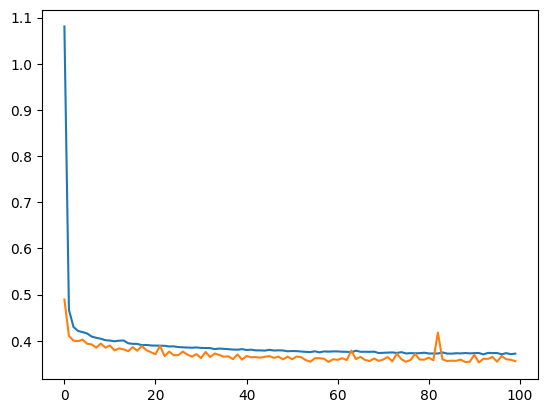

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

В целом нейронка бышла вышла на плато, ROC_AUC порядка 0.88

#### Проверим на тестовой

In [72]:

df_test_preprocessed_filled = np.asarray(df_test_preprocessed_filled).astype('float32')

y_pred_proba_test = model_nn.predict(df_test_preprocessed_filled)


output = pd.DataFrame({
    "Id": ids_test,
    "Predicted": y_pred_proba_test.flatten(),
})

output_nn = output.groupby("Id").max().reset_index()

# Сохранение результатов в CSV файл
output_nn.to_csv("answers_nn.csv", index=False)


987/987 [==============================] - 3s 2ms/step


# Вывод:

1. Данные были загружены и изучены на этапе EDA
2. Данные были предобработаны: проскалированы, устранены NaN, созданы дамми переменные для категориальных признаков
3. Были обучены три модели:
  - CatBoost на топ 20 важных фичей и на всех
  - RandomForestClassifier на всех фичах
  - Нейронная сеть на всех фичах

Результаты:
 1. CatBoost на всех фичах: на валидации 0.975, **на тесте 0.9014**
 2. RandomForestClassifier: на валидации 0.95, **на тесте 0.9074**
 3. Нейронка значительно отстает, на тесте 0.88